In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee

from chainconsumer import ChainConsumer, Chain

# 1D Gaussian
## Fit the mean ($\mu$) and the variance ($\sigma^2$)

Data mean:  2.0140650984405792
Data variance:  3.011139398171443


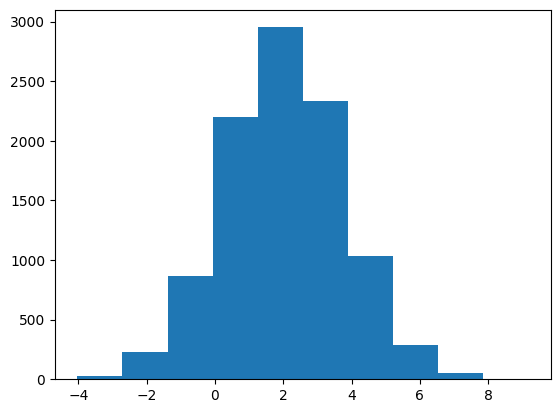

In [189]:
# Create data
mu_true = 2.0
var_true = 3.0

x = np.random.normal(loc=mu_true, scale=np.sqrt(var_true), size=10000)
print("Data mean: ", np.mean(x))
print("Data variance: ", np.var(x))

plt.hist(x)
plt.show()

Assuming uninformative prior,
$$ P(\mu, \sigma^2) \propto (\sigma^2)^{-1}$$

The likelihood function is
$$P(y|\mu,\sigma^2) = \prod_i^n P(y_i | \mu, \sigma^2) \propto \sigma^{-n} \exp\left[-\frac{1}{2}\sum_i \frac{(y_i - \mu)^2}{\sigma^2}\right]$$

Therefore, the negative of the log-posterior is
$$-\ln P = (n + 2)\ln\sigma + \frac{1}{2}\sum_i^n \frac{(y_i - \mu)^2}{\sigma^2}$$

Let's assume $\mu \in [-5, 5]$ and $\sigma^2 \in [1, 10]$.

In [125]:
# Prior boundaries
N_data = len(x)
mu_min, mu_max = -5, 5
var_min, var_max = 1, 10

# Define (homogeneous) Malmquist prior
def log_prior(theta):
    mu, var = theta

    if (mu_min < mu < mu_max) & (var_min < var < var_max):
        return 0.
    
    return -np.inf

# Create "log-posterior" function
def log_probability(theta, x):

    lp = log_prior(theta)
    mu, var = theta
    if not np.isfinite(lp):
        return -np.inf
    
    neg_log_likelihood = (len(x) + 2) * np.log(np.sqrt(var)) + 0.5 * np.sum((x - mu)**2 / var)

    return - neg_log_likelihood

# Initial guesses for mu and var:
mu_0 = np.mean(x)
var_0 = np.var(x)

pos = np.array([mu_0, var_0]) + 0.1 * np.random.randn(8, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x,)
)
sampler.run_mcmc(pos, 10000, progress=True)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True).T

100%|██████████| 10000/10000 [00:02<00:00, 4257.95it/s]


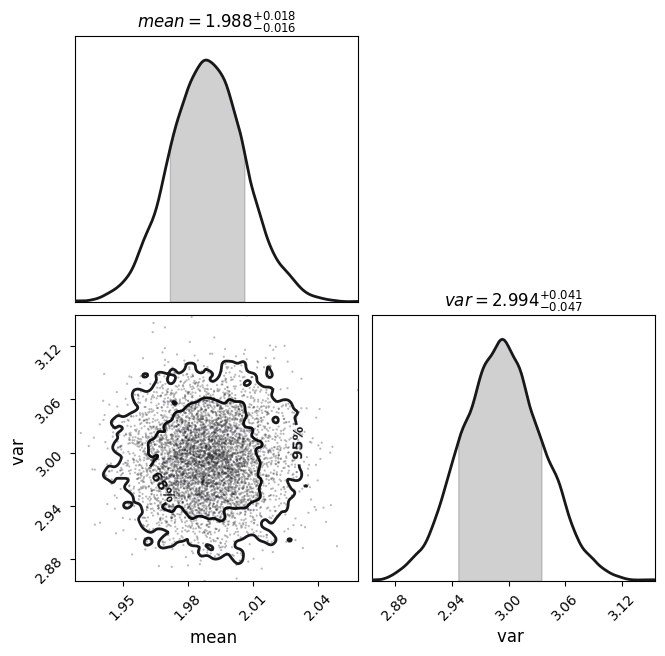

In [129]:
df = pd.DataFrame({'mean': flat_samples[0], 'var': (flat_samples[1])})
C = ChainConsumer()
# C.configure(kde=True, smooth=2)
chain = Chain(
    samples=df,
    name='1D Gaussian',
    color='k',
    plot_point=True,
    plot_cloud=True,
    marker_style='*',
    marker_size=100,
    num_cloud=30000,
    shade=False,
    linewidth=2.0,
    cmap='magma',
    show_contour_labels=True,
)
C.add_chain(chain)
C.plotter.plot()

plt.show()

## Posterior predictive checking

We know that

$$ P(\tilde{y} | y) = \int P(\tilde{y}|\theta, y) P(\theta|y) \mathrm{d}\theta = \int P(\tilde{y}|\theta) P(\theta|y) \mathrm{d}\theta$$

Therefore we can draw future observations in two steps:
1. Sample $\theta = \{\mu, \sigma^2\}$ from the joint posterior density (already done with MCMC).
2. Draw $\tilde{y} \sim \mathcal{N}(\mu, \sigma^2)$ from the drawn values.

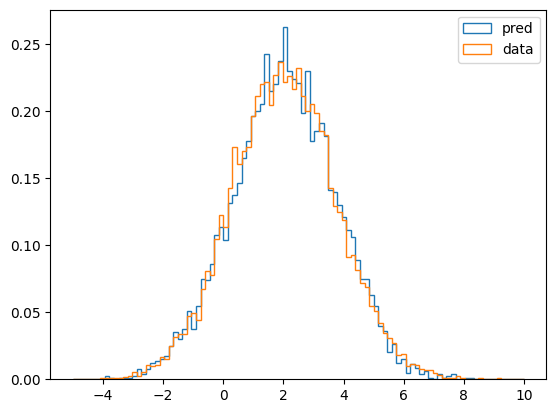

In [194]:
x_pred = np.random.normal(loc=flat_samples[0], scale=np.sqrt(flat_samples[1]))

bins_ = np.linspace(-5, 10, 100)
plt.hist(x_pred, bins=bins_, label='pred', density=True, histtype='step')
plt.hist(x, bins=bins_, label='data', density=True, histtype='step')
plt.legend()

# 2D Gaussian

## Fit the mean ($\mu$) and the covariance matrix ($C$)

Text(0, 0.5, 'y')

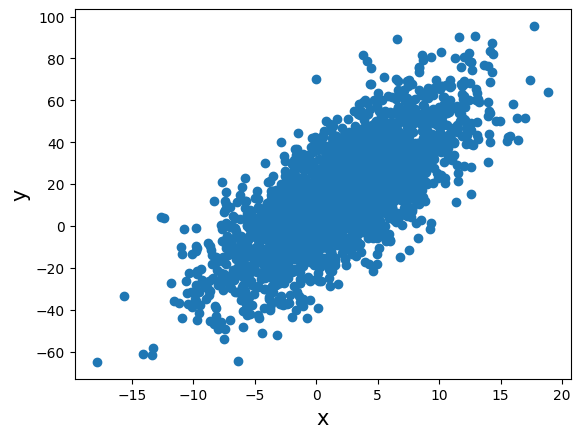

In [176]:
np.random.seed(42)

# Generate data
mean_x = 2.0
mean_y = 15.0
sigma_x = 5.0
sigma_y = 25.0
rho_xy = 0.75
params_true = np.array([mean_x, mean_y, sigma_x**2, sigma_y**2, rho_xy])

mean_vec = np.array([mean_x, mean_y])
cov_matrix = np.array([
    [sigma_x**2, rho_xy * sigma_x * sigma_y],
    [rho_xy * sigma_x * sigma_y, sigma_y**2]
])

x_data, y_data = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=2500).T

plt.scatter(x_data, y_data)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)

For a 2D Gaussian, the likelihood is
$$-\ln \mathcal{L} = \frac{n}{2}\ln|C| + \frac{1}{2}\sum_i^n (y_i - \mu)^\intercal C^{-1} (y_i - \mu)$$

In [183]:
# Prior boundaries
N_data = len(x_data)
mean_x_min, mean_x_max = -5, 5
mean_y_min, mean_y_max = 0, 20
var_x_min, var_x_max = 1, 500
var_y_min, var_y_max = 1, 1000
rho_min, rho_max = 0, 1

var_min, var_max = 1, 10

# Define (homogeneous) Malmquist prior
def log_prior(theta):
    mean_x, mean_y, var_x, var_y, rho = theta

    if (mean_x_min < mean_x < mean_x_max) & (mean_y_min < mean_y < mean_y_max) & (var_x_min < var_x < var_x_max) &\
    (var_y_min < var_y < var_y_max) & (rho_min < rho < rho_max):
        return 0.
    
    return -np.inf

# Create "log-posterior" function
def log_probability(theta, r):

    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    mean_x, mean_y, var_x, var_y, rho = theta

    # Mean vector, determinant and inverse of covariance matrix
    mean_vec = np.array([mean_x, mean_y])
    det_cov_mat = (1 - rho**2) * (var_x * var_y)
    inv_cov_mat = (1 / det_cov_mat) * np.array([
        [var_y, -rho * np.sqrt(var_x * var_y)],
        [-rho * np.sqrt(var_x * var_y), var_x]
    ])
    
    neg_log_likelihood = (r.shape[0] / 2) * np.log(det_cov_mat) + 0.5 * np.sum((r - mean_vec) @ inv_cov_mat * (r - mean_vec))

    return - neg_log_likelihood

# Initial guesses for mu and var:
mean_x_0 = np.mean(x_data)
mean_y_0 = np.mean(y_data)
var_x_0 = np.var(x_data)
var_y_0 = np.var(y_data)
rho_0 = 0.1

pos = np.array([mean_x_0, mean_y_0, var_x_0, var_y_0, rho_0]) + 0.1 * np.random.randn(16, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(np.vstack([x_data, y_data]).T,)
)
sampler.run_mcmc(pos, 5000, progress=True)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True).T

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/mrafifrbbn/Documents/phd_projects/project_1/numpyro-tutorial/.venv/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:03<00:00, 1355.69it/s]


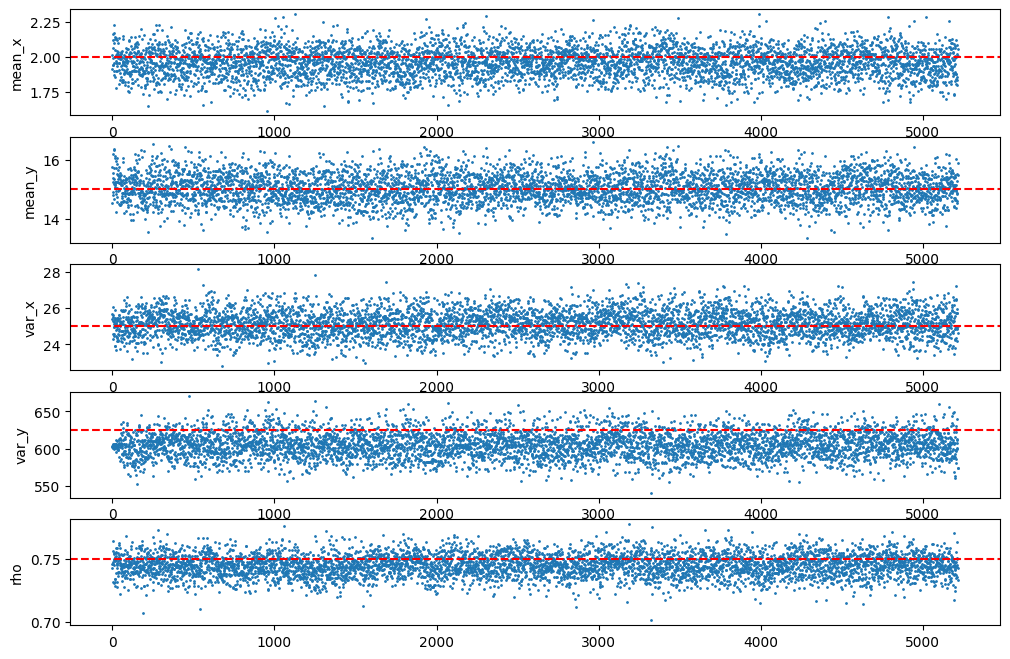

In [184]:
param_names = ['mean_x', 'mean_y', 'var_x', 'var_y', 'rho']

fig, axs = plt.subplots(nrows=len(param_names), figsize=(12, 8))

for i, param_name in enumerate(param_names):
    ax = fig.axes[i]
    ax.scatter(list(range(0, flat_samples.shape[1])), flat_samples[i], s=1)
    ax.set_ylabel(param_names[i])

    # ax.axvline(x=500, c='r', ls='--')
    ax.axhline(y=params_true[i], c='r', ls='--')

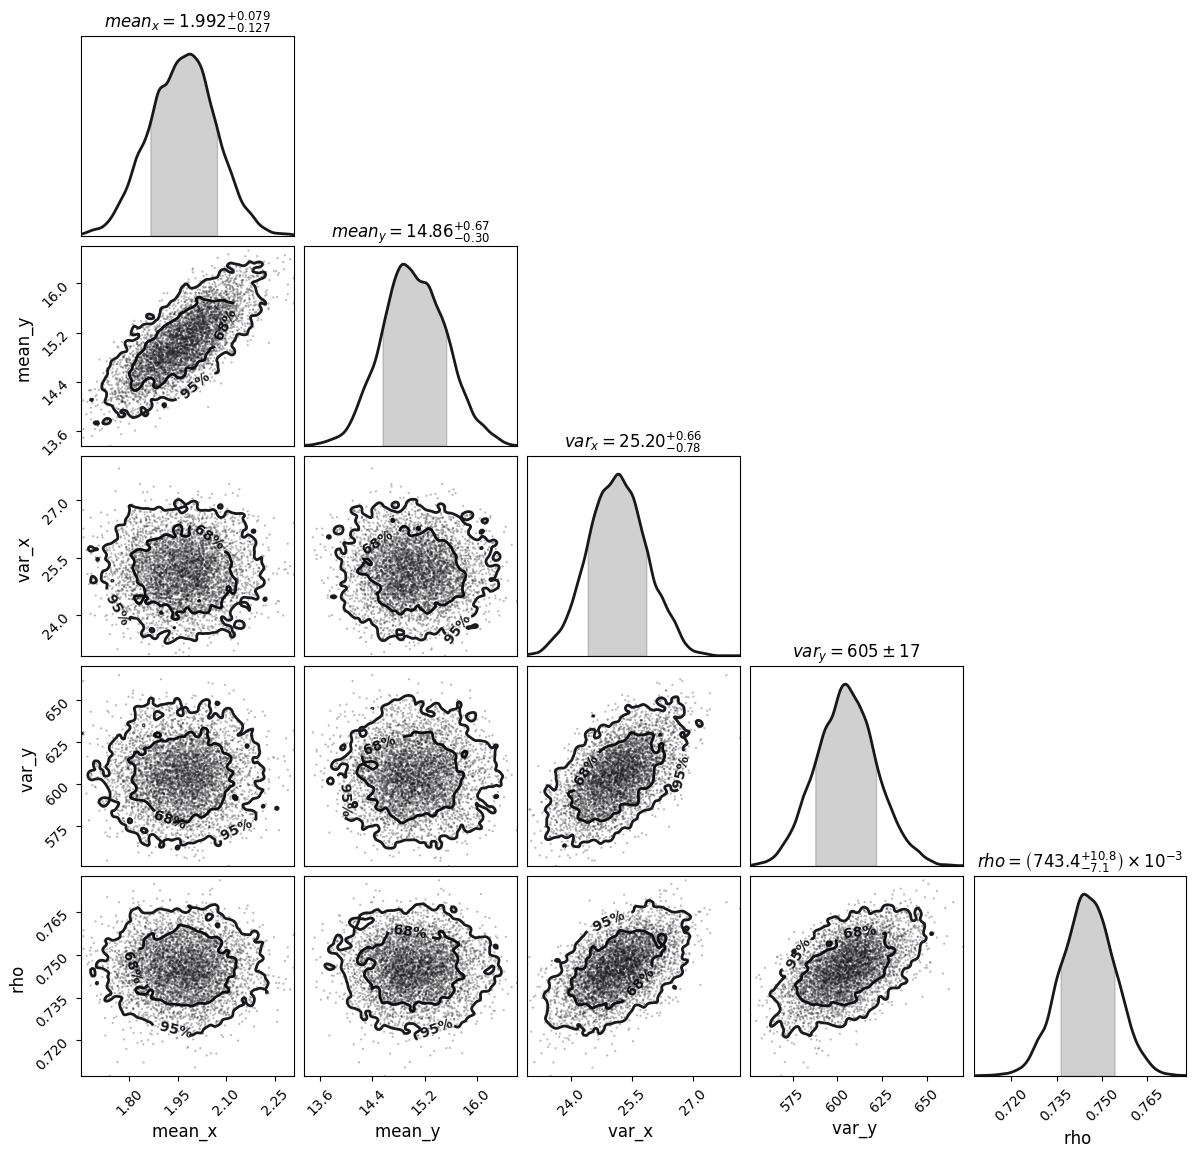

In [185]:
chains = flat_samples[:, 0:]

df = pd.DataFrame({
    'mean_x': chains[0],
    'mean_y': chains[1],
    'var_x': chains[2],
    'var_y': chains[3],
    'rho': chains[4],
})
C = ChainConsumer()
# C.configure(kde=True, smooth=2)
chain = Chain(
    samples=df,
    name='2D Gaussian',
    color='k',
    plot_point=True,
    plot_cloud=True,
    marker_style='*',
    marker_size=100,
    num_cloud=30000,
    shade=False,
    linewidth=2.0,
    cmap='magma',
    show_contour_labels=True,
)
C.add_chain(chain)
C.plotter.plot()

plt.show()

## Posterior predictive check

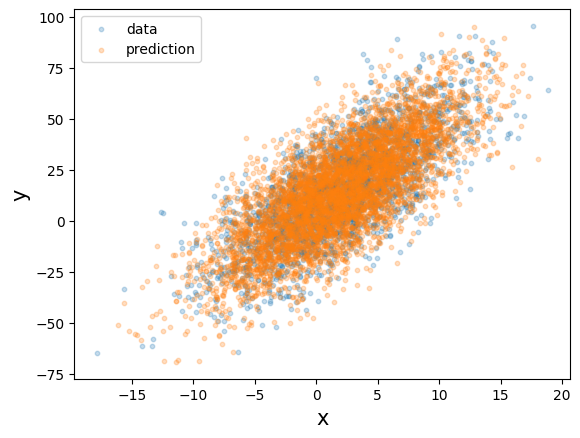

In [198]:
x_pred = []
y_pred = []

for i in range(flat_samples.shape[1]):
    mean_x = flat_samples[0][i]
    mean_y = flat_samples[1][i]
    var_x = flat_samples[2][i]
    var_y = flat_samples[3][i]
    rho = flat_samples[4][i]

    mean_vec = np.array([mean_x, mean_y])
    cov_mat = np.array([
        [var_x, rho * np.sqrt(var_x * var_y)],
        [rho * np.sqrt(var_x * var_y), var_y]
    ])

    x_, y_ = np.random.multivariate_normal(mean=mean_vec, cov=cov_mat)

    x_pred.append(x_)
    y_pred.append(y_)

x_pred = np.array(x_pred)
y_pred = np.array(y_pred)

# Plot data vs prediction distribution
plt.scatter(x_data, y_data, label='data', s=10, alpha=0.25)
plt.scatter(x_pred, y_pred, label='prediction', s=10, alpha=0.25)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend()